In [50]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.optimize import minimize
import batman
import math

In [51]:
# ----------------------
# RV and Transit MODEL
# ----------------------
def transit_model(times, params_dict):
    """
    Return batman transit model flux for given times and params_dict.
    params_dict should include:
      t0, per, rp (Rp/Rs), a (a/Rs), inc (deg), ecc, w (deg), u1, u2, baseline
    """
    params = batman.TransitParams()
    params.t0 = params_dict["t0b"]
    params.per = params_dict["Pb"]
    params.rp = params_dict["rp"]
    params.a = params_dict["a"]
    params.inc = params_dict["inc"]
    params.ecc = params_dict["eb"]
    params.w = params_dict["wb"]
    params.u = [params_dict.get("u1", 0.1), params_dict.get("u2", 0.3)]
    params.limb_dark = "quadratic"
    fac = 0.018
    m = batman.TransitModel(params, times, fac = fac, supersample_factor=7, exp_time= np.median(np.diff(times)))
    model = m.light_curve(params)
    
    return model

def trapezoid_eclipse(times, params_dict, baseline=1.0):
    """
    Simple trapezoidal eclipse model from BATMAN.
    """
    params = batman.TransitParams()
    params.t0 = params_dict["t0b"]
    params.per = params_dict["Pb"]
    params.rp = params_dict["rp"]
    params.a = params_dict["a"]
    params.inc = params_dict["inc"]
    params.ecc = params_dict["eb"]
    params.w = params_dict["wb"]
    params.u = [params_dict.get("u1", 0.1), params_dict.get("u2", 0.3)]
    params.limb_dark = "quadratic"
    params.fp = params_dict["fp"] 
    
    m = batman.TransitModel(params, times)
    params.t_secondary = m.get_t_secondary(params)
    m = batman.TransitModel(params, times, supersample_factor=7, exp_time= np.median(np.diff(times)), transittype="secondary")
    model = m.light_curve(params) 
    return model

def solve_kepler(M, e):
    E = M
    for _ in range(50):
        f = E - e*np.sin(E) - M
        fprime = 1 - e*np.cos(E)
        E -= f/fprime
    return E

def true_anomaly(t, P, tc, e):
    P_days = P
    M = 2*np.pi*(t - tc)/P_days  
    M = np.mod(M, 2*np.pi)
    E = np.array([solve_kepler(mi, e) for mi in M])
    nu = 2*np.arctan2(np.sqrt(1.0+e)*np.sin(E/2), np.sqrt(1.0-e)*np.cos(E/2))
    return nu

def rv_model(times, params):
    """
    Keplerian RV model for two planets.
    params = dict with keys:
        gamma, jitter_rv
        for planet b: Pb, t0b, eb, wb, Kb
        for planet c: Pc, t0c, ec, wc, Kc
    """
    #print('paramerters = ' , params)
    rv = np.zeros_like(times) + params["gamma"]
    # Planet b
    fb = true_anomaly(times, params["Pb"], params["t0b"], params["eb"])
    rv += params["Kb"] * (np.cos(fb + np.deg2rad(params["wb"])) + params["eb"]*np.cos(np.deg2rad(params["wb"])))
    # Planet c
    fc = true_anomaly(times, params["Pc"], params["t0c"], params["ec"])
    rv += params["Kc"] * (np.cos(fc + np.deg2rad(params["wc"])) + params["ec"]*np.cos(np.deg2rad(params["wc"])))
    return rv

# ----------------------
# PRIORS
# ----------------------
def log_prior(theta):
    # adding transit fitting parameters in to theta
    Kb, eb, wb, t0c, Pc, Kc, ec, wc, gamma, \
    rp, u1, u2, fp, inc, a, jitter, c0, c1 = theta

    t0b = 2459958.7472685 
    Pb = 5.72148763
    
    eb2 = eb**2.0+wb**2.0
    wb2 = np.arctan2(eb, wb)/np.pi*180.0
    ec2 = ec**2.0+wc**2.0
    wc2 = np.arctan2(ec, wc)/np.pi*180.0
    #print('eb, wb, ec, wc  ====', eb2, wb2, ec2, wc2)

    # Priors (change as appropriate for your case)
    if not (900 <= Pc < 1360 and (2458550.0) <= t0c < 2459360.0):
        return -np.inf
    if not (0.001 <= eb2 <= 0.30 and 0.01 <= ec2 <= 0.5): 
        return -np.inf
    if not (50 < wb2 < 100 and -180.0 < wc2 < +180.0):
        return -np.inf
    if not (6 < Kb < 26 and 2 < Kc < 20): 
        return -np.inf
    if not (-5 < gamma < 10): 
        return -np.inf
    if not (0.14 < rp < 0.15): 
        return -np.inf
    if not (86.3 <= inc <= 90.0): 
        return -np.inf
    if not (0.2e-4 <= fp <= 1.4e-4): 
        return -np.inf # secondary sub-stellar point offset
#     q1 = 2*np.sqrt(u1)*u2
#     q2 = np.sqrt(u1)*(1 - 2*u2)
    if not (0.01 < u1 <= 0.15 and 0.01 < u2 <= 0.80 ): 
        return -np.inf # u1和u2实际是q1和q2    
    if not (1.0 < jitter <= 7.0): 
        return -np.inf # 
    if not (-2e-4 < c0 <= 1e-4 and -0.002 < c1 <= -0.0005):  #-0.000046, -0.001366
        return -np.inf # 
    if not (12.0 < a < 22.0): 
        return -np.inf  #稍后可以尝试a不变的情况
    
# #     #without prior on a
#     return 0.0
    #with prior
    mu_a, sigma_a = 17.7, 0.7  # from previous paper
    log_p_a = -0.5 * ((a - mu_a) / sigma_a) ** 2
    return 0.0+log_p_a


# Likelihood (includes RV + eclipse time constraint)
def log_likelihood(theta, t, rv, rv_err):    
    Kb, eb, wb, t0c, Pc, Kc, ec, wc, gamma, \
    rp, u1, u2, fp, inc, a, jitter, c0, c1 = theta
        
    Pb = 5.72148763
    t0b = 2459958.7472685 ## 2459958.74727089

    #  using eb = \sqrt(e) cos omega and wb = \sqrt(e) sin omega as parameters.
    eb2 = eb**2.0+wb**2.0
    wb2 = np.arctan2(eb, wb)/np.pi*180.0
    ec2 = ec**2.0+wc**2.0
    wc2 = np.arctan2(ec, wc)/np.pi*180.0
#     print(" e w pre ======", eb, wb, ec, wc)
#     print(" e w  ======", eb2, wb2, ec2, wc2)
    rv_params = dict(gamma=gamma, Pb=Pb, t0b=t0b, eb=eb2, wb=wb2, Kb=Kb,
                     Pc=Pc, t0c=t0c, ec=ec2, wc=wc2, Kc=Kc)
    model_rv = rv_model(t, rv_params)

    bo_large = 1.0 # default 1.0, playing with the RV fitting weight
#    var = rv_err**2*bo_large # enlarge the rv fitting error, to decrease its significance.
    var = rv_err**2.0+jitter**2.0# enlarge the rv fitting error, to decrease its significance.

    return -0.5*np.sum((rv - model_rv)**2 / var + np.log(2*np.pi*var))

def lnlike_transit(theta, times, flux, ferr):

    Kb, eb, wb, t0c, Pc, Kc, ec, wc, gamma, \
    rp, u1, u2, fp, inc, a, jitter, c0, c1 = theta
    Pb = 5.72148763
    t0b = 2459958.7472685 ## 2459958.74727089
    
    # using eb = \sqrt(e) cos omega and wb = \sqrt(e) sin omega as parameters.
    eb2 = eb**2.0+wb**2.0
    wb2 = np.arctan2(eb, wb)/np.pi*180.0
#     print(" e w  ======", eb, wb)
#     print(" e w  ======", eb2, wb2)

    # ec and wc not relevant here
#     ec2 = ec**2.0+wc**2.0
#     wc2 = np.arctan2(ec, wc)

    #a = 16.8
    #fp = 9e-5
    q1 = 2*np.sqrt(u1)*u2
    q2 = np.sqrt(u1)*(1 - 2*u2)
    params = {"t0b": t0b, "Pb": Pb, "rp": rp, "a": a, "inc": inc, "eb": eb2, "wb": wb2, 
              "u1": q1, "u2": q2, "fp":fp}
    params = {"t0b": t0b, "Pb": Pb, "rp": rp, "a": a, "inc": inc, "eb": eb2, "wb": wb2, 
              "u1": q1, "u2": q2, "fp":fp}

    times1 = times[0:1289]   # primary obs, 
    times2 = times[1289:] # secondary obs
    model1 = transit_model(times1, params)
    model2 = trapezoid_eclipse(times2, params)
    model2 = model2+ c0 + c1*(times2 - np.median(times2))
    model = np.concatenate( [model1, model2])
    # no jitter
    #jitter = np.exp(log_jit)
    var = ferr**2 
    #var[0:1289] = var[0:1289]*1.0  # playing with the transit weight
    re_val = (flux - model)**2 / var + np.log(2*np.pi*var)
    re_val2 = -0.5 * np.sum (re_val[0:1289] ) -0.5*np.sum(re_val[1289:]) # remove the first 10 mins data due to JWST ramp
    return re_val2

def log_probability(theta, t, rv, rv_err, times, flux, ferr):
    lp = log_prior(theta)
#    print('lp = ', lp)
    if not np.isfinite(lp):
        return -np.inf
    #return lp + lnlike_transit(theta, times, flux, ferr) # only transit
    return lp + log_likelihood(theta, t, rv, rv_err) + lnlike_transit(theta, times, flux, ferr) #transit and RV


ferr secondary =  [0.00055783 0.00055821 0.00055726 ... 0.00055688 0.00055734 0.0005579 ]


sdddev  of secondary =  0.0005960308743079675
length of primary and secondary  =   1289 4678


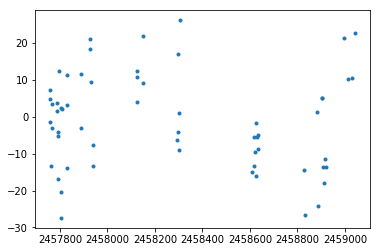

In [52]:
# read in secondary data after remove the first ~100 data affect by JWST ramp
data = np.loadtxt('data_backup/secondary.txt', dtype=float)
times_tr = data[:, 0]
flux_tr = data[:, 1]
ferr_tr = data[:, 2]   
# secondary de-trend, not detrending when fitting the detrend parameters
ferr_tr *= 5.4  # JWST error parameter
print('ferr secondary = ', ferr_tr)

plt.figure()
plt.plot(times_tr, flux_tr, '.')
plt.title('secondary after detrend')
plt.show()
print('sdddev  of secondary = ', np.std(flux_tr))

#primary 数据
#1289 datapoints
# load corresponding data
data = np.loadtxt('data_backup/primary_transit.txt', dtype=float, skiprows=16)

times_tr2 = data[:, 0]
## detrending primary data from JWST modeling result
flux_tr2 = data[:, 3]/(1.0070572438790042-0.0014440479133564154*(times_tr2 - np.median(times_tr2))  ) 
ferr_tr2 = data[:, 4]
times_tr2 = times_tr2 + 2400000.5

print('length of primary and secondary  =  ', len(times_tr2), len(times_tr) )
times_tr = np.concatenate( [ times_tr2, times_tr ] )
flux_tr = np.concatenate(  [ flux_tr2,  flux_tr ] )
ferr_tr = np.concatenate(  [ ferr_tr2,  ferr_tr ] )

# next read in the RV data
data = np.loadtxt('data_backup/rv.txt', skiprows=22)
#only use HIRES 
t = data[0:60, 0]
rv    = data[0:60, 1]
rv_err = data[0:60, 2]
tel_rv   = data[0:60, 3]

# #using all RV
# t = data[0:, 0]
# rv    = data[0:, 1]
# rv_err = data[0:, 2]
# tel_rv   = data[0:, 3]

# check rv data
plt.figure()
plt.plot(t, rv, '.')
plt.show()

# ----------------------
# USER INPUTS
# ----------------------
Mstar = 0.69  # stellar mass [Msun]
Mstar *= 1.98847e30  # convert to kg
G = 6.67430e-11

# ----------------------
# INITIALIZE SAMPLER
# ----------------------
# Initial guess (tweak to your problem)
t0_init =  2459958.7472685e0 # primary transit time
per_init = 5.72148763 # Pb
rp_init = 0.1437  #0.144586
a_init = 16.5 #16.8
inc_init = 89.59
wb_init = 74.83
#ecc_init = 0.12
#w_init = 86.0
u1_init = 0.065
u2_init = 0.30
baseline_init = 1.0
log_jit_init = np.log(1e-4)
off_phase = 0.0
fp = 9e-5
amp = 1e-3
jitter_initial = 3.9
c0_initial = -0.000046 
c1_initial = -0.001366

initial = np.array([14.2, 0.336, 0.053, 2458940.0, 1088.0, 9.3, -0.46, -0.175, 1.5, 
                    rp_init, u1_init, u2_init, fp, inc_init, a_init, 
                    jitter_initial, c0_initial, c1_initial])

nwalkers = 80
ndim = len(initial)
pos = initial + 1e-10 * np.random.randn(nwalkers, ndim)

##### initial position of the chains, usually does not matter. Better start near the optimized position
pos[:, 0] += (1 * np.random.randn(nwalkers))   # Kb
pos[:, 1] +=  np.random.uniform(-0.001, 0.001, nwalkers)  # eb = \sqrt(eb) sin wb, 
pos[:, 2] +=  np.random.uniform(-0.001, 0.001, nwalkers)  # wb = \sqrt(eb) cos wb 
pos[:, 3] += (20*np.random.randn(nwalkers)) #t0c
pos[:, 4] += (30*np.random.randn(nwalkers)) #Pc
pos[:, 5] += (1 * np.random.randn(nwalkers)) #Kc
pos[:, 6] +=  np.random.uniform(-0.001, 0.001, nwalkers) # ec = \sqrt(ec) sin wc
pos[:, 7] +=  np.random.uniform(-0.001, 0.001, nwalkers) # wc = \sqrt(ec) cos wc 
pos[:, 8] = +np.random.uniform(-3, 3, nwalkers) # gamma 
pos[:, 9] += 0.0003*np.random.randn(nwalkers) # rp 
pos[:, 10] += 0.01*np.random.randn(nwalkers) #q1
pos[:, 11] += 0.02*np.random.randn(nwalkers)  # q2 
pos[:, 12] = np.random.uniform( 0.7e-4,  0.9e-4, nwalkers) # fp 
pos[:, 13] += 0.1*np.random.randn(nwalkers)  # inc
pos[:, 14] = np.random.uniform( 15.1,  17.9, nwalkers)  # a
pos[:, 15] += np.random.uniform( -1, 1, nwalkers)  # rv_jitter
pos[:, 16] += np.random.uniform( -1e-5, 1e-5, nwalkers) # c0, detrend 
pos[:, 17] += np.random.uniform( -1e-5, 1e-5, nwalkers) # c1, detrend

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads = 4,  
                                args=(t, rv, rv_err, times_tr, flux_tr, ferr_tr)) # threads = 4 if your cpu has 4 cores


In [1]:
print("Running MCMC...")
total_steps = 10000
sampler.run_mcmc(pos, total_steps)

In [2]:
def gelman_rubin(chain):
    M, N = chain.shape
    mean_per_chain = np.mean(chain, axis=1)
    B = N * np.var(mean_per_chain, ddof=1)
    W = np.mean(np.var(chain, axis=1, ddof=1))
    var_hat = (N-1)/N * W + B/N
    Rhat = np.sqrt(var_hat / W)
    return Rhat

rhat = gelman_rubin(sampler.chain[:, 0:, 0])  # for parameter 0
print(rhat) # if rhat samller than 1.1, means converge. 

In [8]:
# ### if not converge，reset，and continue run the chain
# pos = sampler.chain[:, -1, :]  # last step as new initial position
# sampler.reset()                # clear chain if needed
# sampler.run_mcmc(pos, 8000)

In [44]:
burnin = 2000
samples = np.copy(sampler.chain[:, 2000:, :].reshape((-1, ndim)))
np.save('samples.npy', samples)


RV parameter summary:
Kb = 14.032607737575 (+0.78012517 / -0.79113125)
eb = 0.09372105427163 (+0.019740083 / -0.018586301)
wb = 79.4516296572792 (+2.3571034 / -2.6631571)
t0c = 2458924.72402819 (+64.619875 / -68.03018)
Pc = 1066.4665078756 (+23.543175 / -24.676574)
Kc = 9.31282606865442 (+0.99015146 / -0.94552626)
ec = 0.268769929621955 (+0.078690129 / -0.07356575)
wc = 246.737346978896 (+25.704264 / -29.240367)
gamma = 1.30804388670634 (+0.71620754 / -0.70000075)
rp = 0.143686925381614 (+0.00030211014 / -0.00028879314)
u1 = 0.0668304760847032 (+0.019684241 / -0.016875203)
u2 = 0.292529143898396 (+0.10560288 / -0.081274351)
fp = 8.54912109417047e-05 (+1.8473106e-05 / -1.8595843e-05)
inc = 89.5462538420862 (+0.25274009 / -0.18338798)
a = 16.4697904881288 (+0.32198621 / -0.33527026)
jitter = 3.99838918875266 (+0.50131597 / -0.43650326)
c0 = -5.31919268760902e-05 (+1.500205e-05 / -1.4251687e-05)
c1 = -0.00142840584854944 (+8.609986e-05 / -9.1482096e-05)
-------------------
--------------

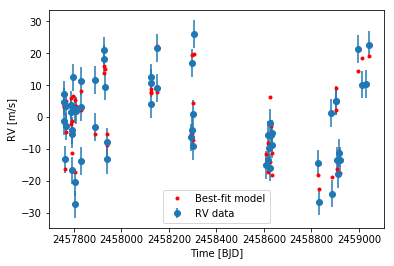

In [53]:
burnin = 2000
samples = np.copy(sampler.chain[:, burnin:, :].reshape((-1, ndim)))
# can also load old-run results
#samples = np.load('sample_bolarge1_u_range_fix_tb_HIRES_prior_offset_e-w_jitter_detrend2.npy')

# becareful, when run the code, different runs will return slightly different results (mcmc). 
ebs = samples[:, 1]
wbs = samples[:, 2]
ecs = samples[:, 6]
wcs = samples[:, 7]

ebs2 = ebs**2.0+wbs**2.0
wbs2 = np.arctan2(ebs, wbs)/np.pi*180.0
ecs2 = ecs**2.0+wcs**2.0
wcs2 = np.arctan2(ecs, wcs)/np.pi*180.0
wcs2[np.where(wcs2 < 50)] +=360.0 

samples[:, 1] = ebs2
samples[:, 2] = wbs2
samples[:, 6] = ecs2
samples[:, 7] = wcs2

Kb_mcmc, eb_mcmc, wb_mcmc, t0c_mcmc, Pc_mcmc, Kc_mcmc, ec_mcmc, wc_mcmc, gamma_mcmc, \
rp_mcmc, u1_mcmc, u2_mcmc,  \
fp_mcmc, inc_mcmc, a_mcmc, jitter_mcmc, \
c0_mcmc, c1_mcmc = np.median(samples, axis=0)

t0b_mcmc = 2459958.7472685 ## 2459958.74727089
Pb_mcmc = 5.72148763

# for processing jitter
data = np.loadtxt('data_backup/rv.txt', skiprows=22)
data[60:, 1] = data[60:, 1]-2.0 #offset between two runs, reducing CORAIL value  
#only use HIRES 
t = data[0:60, 0]
rv    = data[0:60, 1]
rv_err = data[0:60, 2]
tel_rv   = data[0:60, 3]
rv_err = (rv_err**2.0+jitter_mcmc**2.0)**0.5

def summary(samples, names):
    med = np.median(samples, axis=0)
    lo = np.percentile(samples, 16, axis=0)
    hi = np.percentile(samples, 84, axis=0)
    for i, name in enumerate(names):
        print(f"{name} = {med[i]:.15g} (+{hi[i]-med[i]:.8g} / -{med[i]-lo[i]:.8g})")
    # making conor plot
    #fig = corner.corner(samples, labels=names,
    #                  truths=[K_mcmc, e_mcmc, omega_mcmc, gamma_mcmc])
    #fig.savefig("triangle.png")

def summary2(samples, names):
    med = np.median(samples, axis=0)
    lo = np.percentile(samples, 0.15, axis=0)
    hi = np.percentile(samples, 99.85, axis=0)
    for i, name in enumerate(names):
        print(f"{name} = {med[i]:.15g} (+{hi[i]-med[i]:.8g} / -{med[i]-lo[i]:.8g})")
        
        
def summary3(samples, names):
    med = np.median(samples, axis=0)
    lo = np.percentile(samples, 2.5, axis=0)
    hi = np.percentile(samples, 97.5, axis=0)
    for i, name in enumerate(names):
        print(f"{name} = {med[i]:.15g} (+{hi[i]-med[i]:.8g} / -{med[i]-lo[i]:.8g})")
        
        
def summary4(samples, names):
    med = np.median(samples, axis=0)
    lo = np.percentile(samples, 0.00003, axis=0)
    hi = np.percentile(samples, 99.99997, axis=0)
    for i, name in enumerate(names):
        print(f"{name} = {med[i]:.15g} (+{hi[i]-med[i]:.8g} / -{med[i]-lo[i]:.8g})")
        
print("\nRV parameter summary:")
trans_names = ["Kb", "eb", "wb", "t0c", "Pc", "Kc", "ec", "wc", "gamma", 
              "rp","u1","u2", "fp", "inc", "a", "jitter", 'c0', 'c1']
summary(samples, trans_names)
print('-------------------')
print('-------------------')
print('-------------------')

summary3(samples, trans_names)

print('-------------------')
print('-------------------')
print('-------------------')

summary2(samples, trans_names)


print('-------------------')
print('-------------------')
print('-------------------')

summary4(samples, trans_names)


# ----------------------
# Convert K -> planet mass
# ----------------------
Mstar = 0.69 
Mstar *= 1.98847e30  # convert to kg
G = 6.67430e-11

Mp_sini = (Kb_mcmc * (Mstar**(2/3)) * np.sqrt(1.0-eb_mcmc**2) * (Pb_mcmc*86400.0/(2*np.pi*G))**(1/3))
Mp_sini /= 1.898e27  # Jupiter masses

print(f"Mp*sin(i) = {Mp_sini:.3f} Mjup")
Mp2_sini = (Kc_mcmc * (Mstar**(2/3)) * np.sqrt(1.0-ec_mcmc**2) * (Pc_mcmc*86400.0/(2*np.pi*G))**(1/3))
Mp2_sini /= 1.898e27  # Jupiter masses
print(f"Mp2*sin(i) = {Mp2_sini:.3f} Mjup")

########### making rv plot
plt.errorbar(t, rv, rv_err, fmt='o', label='RV data')

rv_params = dict(gamma=gamma_mcmc, Pb=Pb_mcmc, t0b=t0b_mcmc, eb=eb_mcmc, wb=wb_mcmc, Kb=Kb_mcmc,
                     Pc=Pc_mcmc, t0c=t0c_mcmc, ec=ec_mcmc, wc=wc_mcmc, Kc=Kc_mcmc)
    
model_rv = rv_model(t, rv_params)
plt.plot(t, model_rv, 'r.', label='Best-fit model')
plt.xlabel('Time [BJD]')
plt.ylabel('RV [m/s]')
plt.legend()
plt.show()

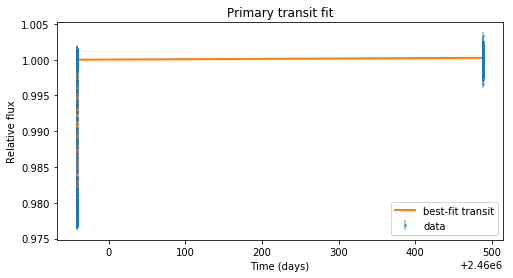

median res primary =   -0.7821587479917014 3.807448645004273 ppm
std res primary =   519.8125180739116  ppm
median res secondary =   -8.897577038924354 -5.425094946769626 ppm
std res secondary =   579.7516721651685  ppm
error primary =  0.0005272858303753646
error secondary =   0.0005578617880498474


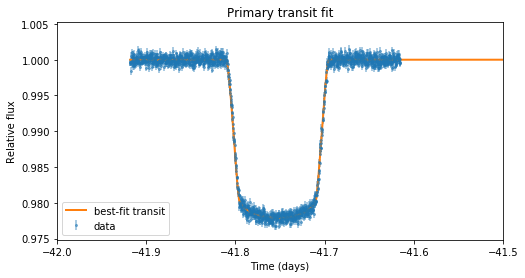

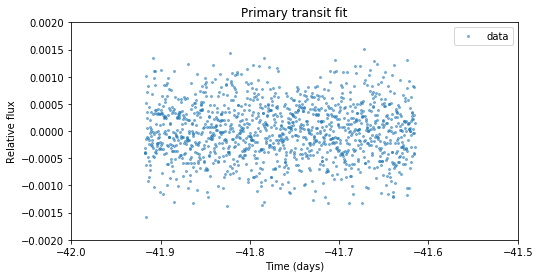

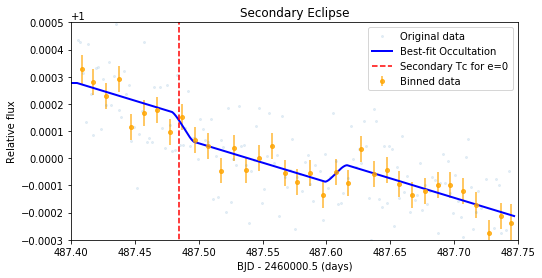

In [54]:
trans_medians = np.median(samples, axis=0)
best_phot_params = dict(zip( ["Kb", "eb", "wb", "t0c", "Pc", "Kc", "ec", "wc", "gamma", 
              "rp","u1","u2", "fp", "inc", "a", "jitter", "c0", "c1"], trans_medians ) )

u1 = best_phot_params["u1"]
u2 = best_phot_params["u2"] 
q1 = 2*np.sqrt(u1)*u2
q2 = np.sqrt(u1)*(1 - 2*u2)
best_phot_params["u1"] = q1
best_phot_params["u2"] = q2
best_phot_params["Pb"]  = 5.72148763
best_phot_params["t0b"] = 2459958.7472685 
#print(best_phot_params)

times1 = times_tr[0:1289]   # primary obs, boma
times2 = times_tr[1289:] # secondary time, boma
model1 = transit_model(times1, best_phot_params)
model2 = trapezoid_eclipse(times2, best_phot_params)+c0_mcmc + c1_mcmc*(times2 - np.median(times2))
model_best_photo = np.concatenate( [model1, model2])

plt.figure(figsize=(8,4))
plt.errorbar(times_tr, flux_tr, yerr=ferr_tr, fmt='.', ms=4, alpha=0.5, label='data')
plt.plot(times_tr, model_best_photo, label='best-fit transit', lw=2)
plt.xlabel("Time (days)")
plt.ylabel("Relative flux")
plt.legend()
plt.title("Primary transit fit")
plt.show()

# making binned plots
def bin_lightcurve(times, fluxes, flux_errs, bin_size):
    if not np.all(times[:-1] <= times[1:]):
        sort_idx = np.argsort(times)
        times = times[sort_idx]
        fluxes = fluxes[sort_idx]
        flux_errs = flux_errs[sort_idx]
    
    # 计算分箱边界
    min_time = times.min()
    max_time = times.max()
    bins = np.arange(min_time, max_time + bin_size, bin_size)
    
    binned_times = []
    binned_fluxes = []
    binned_errs = []
    
    # 对每个 bin 计算加权平均
    for i in range(len(bins) - 1):
        mask = (times >= bins[i]) & (times < bins[i+1])
        if np.sum(mask) == 0:
            continue  # 跳过空箱
        
        # 提取该 bin 内的数据
        t_bin = times[mask]
        f_bin = fluxes[mask]
        e_bin = flux_errs[mask]
        
        # 计算加权平均（权重为 1/误差²，减少大误差点的影响）
        weights = 1.0 / (e_bin ** 2)
        weighted_flux = np.sum(f_bin * weights) / np.sum(weights)
        # 分箱后的误差
        bin_err = 1.0 / np.sqrt(np.sum(weights))
        
        # 保存 bin 中心和结果
        #binned_times.append((bins[i] + bins[i+1]) / 2)
        binned_times.append( np.median(t_bin))
        binned_fluxes.append(weighted_flux)
        binned_errs.append(bin_err)
    
    return np.array(binned_times), np.array(binned_fluxes), np.array(binned_errs)

# ----------------------
# 3. 分箱参数设置（根据数据密度调整）
# ----------------------
bin_size = 0.01  # 分箱宽度（单位：天，可根据需要修改，如0.001或0.01）
#bin_size = 0.005  # 分箱宽度（单位：天，可根据需要修改，如0.001或0.01）
# 对时间进行同样的偏移（与绘图时一致）
adjusted_times = times_tr - 2460000.5
# 执行分箱
binned_t, binned_f, binned_e = bin_lightcurve(
    adjusted_times, 
    flux_tr, 
    ferr_tr, 
    bin_size=bin_size
)

binned_t2, binned_f2, binned_e2 = bin_lightcurve(
    adjusted_times, 
    flux_tr, 
    ferr_tr, 
    bin_size=0.002
)


# ----------------------
# 4. 绘图（对比原始数据和分箱后数据）
# ----------------------
plt.figure(figsize=(8, 4))

# 原始数据（可选，用浅色显示）
plt.errorbar(adjusted_times, flux_tr, yerr=ferr_tr, 
             fmt='.', ms=2, alpha=0.2, label='Original data')

# 分箱后的数据（深色，更清晰）
plt.errorbar(binned_t, binned_f, yerr=binned_e, 
             fmt='o', ms=4, alpha=0.8, color='orange', label=f'Binned data (size={bin_size})')

# 最佳拟合模型（保持不变）
plt.plot(adjusted_times, model_best_photo, label='Best-fit transit', lw=2, color='blue')

# 轴标签和标题（保持不变）
plt.xlabel("Time (days)")
plt.ylabel("Relative flux")
plt.legend()
plt.title("Primary transit fit")
plt.xlim(487.35, 487.8)
plt.ylim(0.9997, 1.0005)
plt.show()

plt.figure(figsize=(8,4))
plt.errorbar(times_tr-2460000.5, flux_tr, yerr=ferr_tr, fmt='.', ms=4, alpha=0.5, label='data')
plt.plot(times_tr-2460000.5, model_best_photo, label='best-fit transit', lw=2)
plt.xlabel("Time (days)")
plt.ylabel("Relative flux")
plt.legend()
plt.title("Primary transit fit")
plt.xlim(-42.0,-41.5)

res2  = flux_tr-model_best_photo
print('median res primary =  ', np.median(res2[0:1289])*1e6, np.mean(res2[0:1289])*1e6, 'ppm') #primary
print('std res primary =  ', np.std(res2[0:1289])*1e6, ' ppm')  
print('median res secondary =  ',np.median(res2[1289:])*1e6, np.mean(res2[1289:])*1e6, 'ppm') #secondary
print('std res secondary =  ', np.std(res2[1289:])*1e6, ' ppm')  

print('error primary = ',np.median(ferr_tr[0:1289]))
print('error secondary =  ', np.median(ferr_tr[1289:]))

plt.figure(figsize=(8,4))
plt.plot(times_tr-2460000.5, flux_tr-model_best_photo, '.', ms=4, alpha=0.5, label='data')
plt.xlabel("Time (days)")
plt.ylabel("Relative flux")
plt.legend()
plt.title("Primary transit fit")
plt.xlim(-42.0,-41.5)
plt.ylim(-0.002,0.002)
plt.show()


plt.figure(figsize=(8, 4))
plt.plot(binned_t2, binned_f2,  '.', ms=4, alpha=0.1, label='Original data')
plt.errorbar(binned_t, binned_f, yerr=binned_e, 
             fmt='o', ms=4, alpha=0.8, color='orange', label=f'Binned data')
plt.plot(adjusted_times, model_best_photo, label='Best-fit Occultation', lw=2, color='blue')
plt.plot([487.48483533, 487.48483533], [0, 2], 'r', linestyle='--', label='Secondary Tc for e=0')
plt.xlabel("BJD - 2460000.5 (days)")
plt.ylabel("Relative flux")
plt.legend(loc = 'upper right')
plt.title("Secondary Eclipse")
plt.xlim(487.40, 487.75)
plt.ylim(0.9997, 1.0005)
plt.show()

shape of second =  (34,)
chi^2 of the new fit is =  28.16637957098771
4.297543008678177e-05
residuals =  [ 2.28395022e-05 -1.43175460e-05  5.98230470e-05 -9.93923255e-05
 -3.42747645e-05 -1.06210765e-05 -7.37402634e-05  3.30575343e-05
  3.87649850e-06 -5.32378901e-08 -7.55402456e-05  2.03652632e-05
 -4.45352043e-05  1.47576450e-05  7.05987668e-05 -1.46157612e-05
 -3.12963356e-05  1.51616040e-05 -5.50495242e-05  7.88272792e-06
 -6.09988088e-05  7.38572895e-05 -2.79563901e-06  2.60241273e-05
 -9.96277053e-06 -3.75092063e-05 -6.54920394e-06  2.80149318e-05
  4.25455305e-05  3.65742984e-05 -3.15533727e-06 -9.22082359e-05
 -1.27640736e-05 -2.85016892e-05]


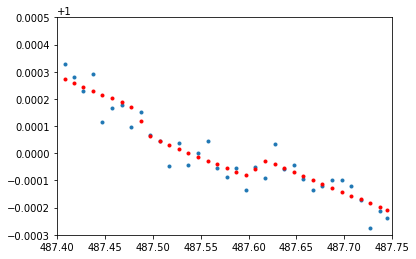

In [55]:
# binned results
model_fs = trapezoid_eclipse(binned_t+ 2460000.5, best_phot_params)+c0_mcmc + c1_mcmc*(binned_t+ 2460000.5 - np.median(times2))
# for binsize = 0.01
second_resi= (binned_f-model_fs)[32:]
second_e = binned_e[32:]
# # for binsize = 0.005
# second_resi= (binned_f-model_fs)[63:]
# second_e = binned_e[63:]
print('shape of second = ', np.shape(second_resi))
print( 'chi^2 of the new fit is = ', np.sum( (second_resi/second_e )**2.0 ))
print(np.std(second_resi))
print('residuals = ', second_resi)

plt.plot(binned_t, binned_f, '.' )
plt.plot(binned_t, model_fs, 'r.'  )
plt.xlim(487.40, 487.75)
plt.ylim(0.9997, 1.0005)
plt.show()

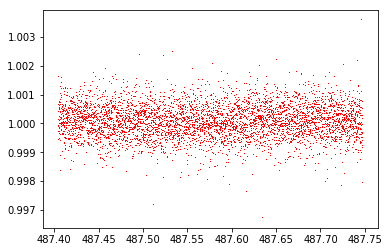

median res primary =   -0.7821587479917014 3.807448645004273 ppm
std res primary =   519.8125180739116  ppm
median res secondary =   -8.897577038813331 -5.4250949467471745 ppm
std res secondary =   579.7516721651692  ppm
error primary =  0.0005272858303753646
error secondary =   0.0005578617880498474


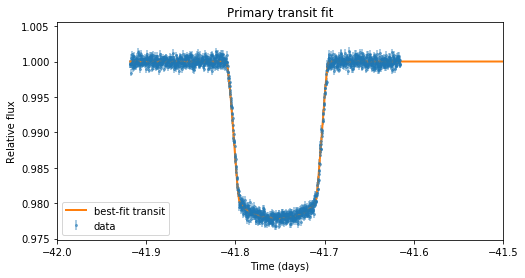

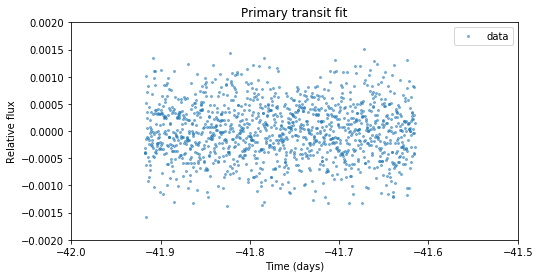

In [56]:
trans_medians = np.median(samples, axis=0)
best_phot_params = dict(zip( ["Kb", "eb", "wb", "t0c", "Pc", "Kc", "ec", "wc", "gamma", 
              "rp","u1","u2", "fp", "inc", "a", "jitter", "c0", "c1"], trans_medians ) )

u1 = best_phot_params["u1"]
u2 = best_phot_params["u2"] 
q1 = 2*np.sqrt(u1)*u2
q2 = np.sqrt(u1)*(1 - 2*u2)
best_phot_params["u1"] = q1
best_phot_params["u2"] = q2
best_phot_params["Pb"]  = 5.72148763
best_phot_params["t0b"] = 2459958.7472685 


times1 = times_tr[0:1289]   # primary obs, boma
times2 = times_tr[1289:] # secondary time, boma
model1 = transit_model(times1, best_phot_params)
model2 = trapezoid_eclipse(times2, best_phot_params)
model_best_photo = np.concatenate( [model1, model2])
#model_best = transit_model(times_tr, best_params)

# ----------------------
# 1. 定义 bin 处理函数（支持误差加权，可选）
# ----------------------
def bin_lightcurve(times, fluxes, flux_errs, bin_size):
    """
    对光变曲线数据进行分箱处理
    参数：
        times: 时间数组（需有序）
        fluxes: 流量数组
        flux_errs: 流量误差数组
        bin_size: 分箱宽度（与时间单位一致）
    返回：
        binned_times: 分箱后的时间（取区间中心）
        binned_fluxes: 分箱后的流量（加权平均）
        binned_errs: 分箱后的误差（加权误差）
    """
    # 确保时间有序（如果无序，先排序）
    if not np.all(times[:-1] <= times[1:]):
        sort_idx = np.argsort(times)
        times = times[sort_idx]
        fluxes = fluxes[sort_idx]
        flux_errs = flux_errs[sort_idx]
    
    # 计算分箱边界
    min_time = times.min()
    max_time = times.max()
    bins = np.arange(min_time, max_time + bin_size, bin_size)
    
    binned_times = []
    binned_fluxes = []
    binned_errs = []
    
    # 对每个 bin 计算加权平均
    for i in range(len(bins) - 1):
        mask = (times >= bins[i]) & (times < bins[i+1])
        if np.sum(mask) == 0:
            continue  # 跳过空箱
        
        # 提取该 bin 内的数据
        t_bin = times[mask]
        f_bin = fluxes[mask]
        e_bin = flux_errs[mask]
        
        # 计算加权平均（权重为 1/误差²，减少大误差点的影响）
        weights = 1.0 / (e_bin ** 2)
        weighted_flux = np.sum(f_bin * weights) / np.sum(weights)
        # 分箱后的误差
        bin_err = 1.0 / np.sqrt(np.sum(weights))
        
        # 保存 bin 中心和结果
        binned_times.append((bins[i] + bins[i+1]) / 2)
        binned_fluxes.append(weighted_flux)
        binned_errs.append(bin_err)
    
    return np.array(binned_times), np.array(binned_fluxes), np.array(binned_errs)

# ----------------------
# 3. 分箱参数设置（根据数据密度调整）
# ----------------------
bin_size = 0.01  # 分箱宽度（单位：天，可根据需要修改，如0.001或0.01）

# 对时间进行同样的偏移（与绘图时一致）
adjusted_times = times_tr - 2460000.5
# when making plots, detrend just the first time, do not detrend multi-times
flux_tr[1289:] = flux_tr[1289:] - 1.0* (c0_mcmc+c1_mcmc*(times2 - np.median(times2))) 
plt.plot(adjusted_times[1289:], flux_tr[1289:], 'r,' )
plt.show()

# bin data
binned_t, binned_f, binned_e = bin_lightcurve(
    adjusted_times, 
    flux_tr, 
    ferr_tr, 
    bin_size=bin_size
)

binned_t2, binned_f2, binned_e2 = bin_lightcurve(
    adjusted_times, 
    flux_tr, 
    ferr_tr, 
    bin_size=0.002
)


# ----------------------
# 4. 绘图（对比原始数据和分箱后数据）
# ----------------------
plt.figure(figsize=(8, 4))

# 原始数据（可选，用浅色显示）
plt.errorbar(adjusted_times, flux_tr, yerr=ferr_tr, 
             fmt='.', ms=2, alpha=0.2, label='Original data')

# 分箱后的数据（深色，更清晰）
plt.errorbar(binned_t, binned_f, yerr=binned_e, 
             fmt='o', ms=4, alpha=0.8, color='orange', label=f'Binned data (size={bin_size})')

# 最佳拟合模型（保持不变）
plt.plot(adjusted_times, model_best_photo, label='Best-fit transit', lw=2, color='blue')

# 轴标签和标题（保持不变）
plt.xlabel("Time (days)")
plt.ylabel("Relative flux")
plt.legend()
plt.title("Primary transit fit")
plt.xlim(487.35, 487.8)
plt.ylim(0.9997, 1.0005)
plt.show()

plt.figure(figsize=(8,4))
plt.errorbar(times_tr-2460000.5, flux_tr, yerr=ferr_tr, fmt='.', ms=4, alpha=0.5, label='data')
plt.plot(times_tr-2460000.5, model_best_photo, label='best-fit transit', lw=2)
plt.xlabel("Time (days)")
plt.ylabel("Relative flux")
plt.legend()
plt.title("Primary transit fit")
plt.xlim(-42.0,-41.5)

res2  = flux_tr-model_best_photo
print('median res primary =  ', np.median(res2[0:1289])*1e6, np.mean(res2[0:1289])*1e6, 'ppm') #primary
print('std res primary =  ', np.std(res2[0:1289])*1e6, ' ppm')  
print('median res secondary =  ',np.median(res2[1289:])*1e6, np.mean(res2[1289:])*1e6, 'ppm') #secondary
print('std res secondary =  ', np.std(res2[1289:])*1e6, ' ppm')  

print('error primary = ',np.median(ferr_tr[0:1289]))
print('error secondary =  ', np.median(ferr_tr[1289:]))

plt.figure(figsize=(8,4))
plt.plot(times_tr-2460000.5, flux_tr-model_best_photo, '.', ms=4, alpha=0.5, label='data')
plt.xlabel("Time (days)")
plt.ylabel("Relative flux")
plt.legend()
plt.title("Primary transit fit")
plt.xlim(-42.0,-41.5)
plt.ylim(-0.002,0.002)
plt.show()


plt.figure(figsize=(8, 4))
plt.plot(adjusted_times, flux_tr, '.', ms=2, alpha=0.1, label='Original data')
plt.errorbar(binned_t, binned_f, yerr=binned_e, 
             fmt='o', ms=4, alpha=0.8, color='orange', label=f'Binned data')
# 最佳拟合模型（保持不变）
plt.plot(adjusted_times, model_best_photo, label='Best-fit Occultation', lw=2, color='blue')
plt.plot([487.48483533, 487.48483533], [0, 2], 'r', linestyle='--', label='Secondary Tc for e=0')
plt.xlabel("BJD - 2460000.5 (days)")
plt.ylabel("Relative flux")
plt.legend(loc = 'upper right')
plt.title("Secondary Eclipse")
plt.xlim(487.40, 487.75)
plt.ylim(0.9997, 1.0005)
#plt.savefig('WASP-107_Eclipse_HIRES_Prior_1207-detrend.pdf')
#WASP-107_Eclipse_HIRES_Prior_1207_jitter upload
plt.show()



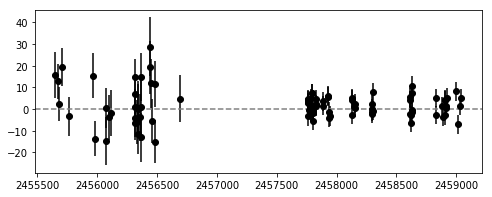

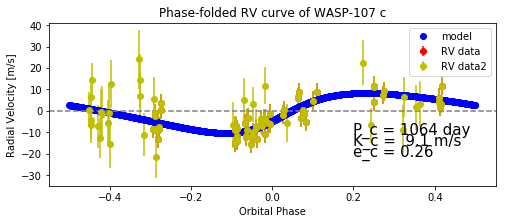

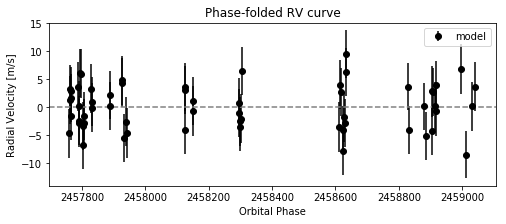

In [57]:
def rv_model_b(times, params):
    """
    Keplerian RV model for two planets.
    params = dict with keys:
        gamma, jitter_rv
        for planet b: Pb, t0b, eb, wb, Kb
        for planet c: Pc, t0c, ec, wc, Kc
    """
    #print('paramerters = ' , params)
    #rv = np.zeros_like(times) + params["gamma"]
    rv = np.zeros_like(times) 

    # Planet b
    fb = true_anomaly(times, params["Pb"], params["t0b"], params["eb"])
    rv += params["Kb"] * (np.cos(fb + np.deg2rad(params["wb"])) + params["eb"]*np.cos(np.deg2rad(params["wb"])))
    return rv

def rv_model_c(times, params):
    """
    Keplerian RV model for two planets.
    params = dict with keys:
        gamma, jitter_rv
        for planet b: Pb, t0b, eb, wb, Kb
        for planet c: Pc, t0c, ec, wc, Kc
    """
    #print('paramerters = ' , params)
    #rv = np.zeros_like(times) + params["gamma"]
    rv = np.zeros_like(times) 
    fc = true_anomaly(times, params["Pc"], params["t0c"], params["ec"])
    rv += params["Kc"] * (np.cos(fc + np.deg2rad(params["wc"])) + params["ec"]*np.cos(np.deg2rad(params["wc"])))
    return rv

def phase_fold(time, rv, rv_err, period, t0):
    """
    Phase fold radial velocity data.

    Parameters
    ----------
    time : array
        Observation times [days]
    rv : array
        Radial velocity measurements [m/s]
    rv_err : array
        Uncertainties in radial velocity [m/s]
    period : float
        Orbital period [days]
    t0 : float
        Reference time (e.g. time of transit or periastron) [days]

    Returns
    -------
    phase : array
        Phase folded values in [-0.5, 0.5]
    rv, rv_err : arrays
        Same as input, reordered
    """
    phase = ((time - t0) / period) % 1.0
    # shift from [0,1) to [-0.5,0.5)
    phase[phase > 0.5] -= 1.0
    return phase, rv, rv_err

#wc_mcmc = 60.0
#rv = rv - gamma_mcmc
#gamma_mcmc = 2.2

rv_params = dict(gamma=gamma_mcmc, Pb=Pb_mcmc, t0b=t0b_mcmc, eb=eb_mcmc, wb=wb_mcmc, Kb=Kb_mcmc,
                      Pc=Pc_mcmc, t0c=t0c_mcmc, ec=ec_mcmc, wc=wc_mcmc, Kc=Kc_mcmc)

ts_model = np.linspace(np.min(t), np.max(t), 1000 )
model_rv_cs = rv_model_c(ts_model, rv_params)
model_rv_bs = rv_model_b(ts_model, rv_params)
rv_errs = ts_model

model_rv_c = rv_model_c(t, rv_params)
model_rv_b = rv_model_b(t, rv_params)

phase, rv_folded_b, rv_err_folded = phase_fold(t, model_rv_b, rv_err, Pb_mcmc, t0b_mcmc)
phase, rv_folded_b2, rv_err_folded = phase_fold(t, rv-(model_rv_c+gamma_mcmc), rv_err, Pb_mcmc, t0b_mcmc)
phase_model_bs, rv_folded_b3, rv_err_folded3 = phase_fold(ts_model, model_rv_bs, rv_errs, Pb_mcmc, t0b_mcmc)
phase_model_cs, rv_folded_c3, rv_err_folded3 = phase_fold(ts_model, model_rv_cs, rv_errs, Pc_mcmc, t0c_mcmc)

# Plot
plt.figure(figsize=(8,3))
#plt.errorbar(phase, rv_folded_b, yerr=rv_err_folded, fmt='o', color='k', label="model")
plt.errorbar(phase, rv_folded_b2, yerr=rv_err_folded, fmt='o', color='r', label="RV data")
plt.plot(phase_model_bs, rv_folded_b3, 'bo', label="model" )
plt.axhline(0, color='gray', ls='--')
plt.xlabel("Orbital Phase")
plt.ylabel("Radial Velocity [m/s]")
plt.title("Phase-folded RV curve of WASP-107 b")
plt.text(-0.44, -11, "P_b = 5.72 day ", fontsize=15, color='black', ha='left')
plt.text(-0.44, -16, "K_b = 14.1 m/s ", fontsize=15, color='black', ha='left')
plt.text(-0.44, -21, "e_b = 0.08", fontsize=15, color='black', ha='left')
plt.legend()
plt.show()


phase2, rv_folded_c, rv_err_folded = phase_fold(t, model_rv_c, rv_err, Pc_mcmc, t0c_mcmc)
phase2, rv_folded_c2, rv_err_folded = phase_fold(t, rv-(model_rv_b+gamma_mcmc), rv_err, Pc_mcmc, t0c_mcmc)

#新添加绘制coralie数据
data = np.loadtxt('data_backup/rv.txt', skiprows=22)
ts = data[:, 0]
rvs    = data[:, 1]
rv_errs = (data[:, 2]**2.0+jitter_mcmc**2.0)**0.5 # adding jitter quadrature

model_rv_b_new = rv_model_b(ts, rv_params)
model_rv_c_new = rv_model_c(ts, rv_params)
##########################
##########################
plt.figure(figsize=(8,3))
plt.errorbar(ts, rvs - model_rv_b_new-model_rv_c_new, yerr = rv_errs, fmt = 'o', color='k')
plt.axhline(0, color='gray', ls='--')
plt.show()

phase2s, rv_folded_c2s, rv_err_foldeds = phase_fold(ts, rvs-(model_rv_b_new+gamma_mcmc), rv_errs, Pc_mcmc, t0c_mcmc)
##########################
##########################
plt.figure(figsize=(8,3))
#plt.errorbar(phase2, rv_folded_c, yerr=rv_err_folded, fmt='o', color='k', label="model")
plt.errorbar(phase2, rv_folded_c2, yerr=rv_err_folded, fmt='o', color='r', label="RV data")
plt.errorbar(phase2s, rv_folded_c2s, yerr=rv_err_foldeds, fmt='o', color='y', label="RV data2")

plt.plot(phase_model_cs, rv_folded_c3, 'bo', label="model" )

plt.axhline(0, color='gray', ls='--')
plt.xlabel("Orbital Phase")
plt.ylabel("Radial Velocity [m/s]")
plt.title("Phase-folded RV curve of WASP-107 c")
plt.legend()
plt.text(0.2, -11, "P_c = 1064 day ", fontsize=15, color='black', ha='left')
plt.text(0.2, -16, "K_c =  9.1 m/s ", fontsize=15, color='black', ha='left')
plt.text(0.2, -21, "e_c = 0.26", fontsize=15, color='black', ha='left')
plt.show()
##########################
##########################

plt.figure(figsize=(8,3))
plt.errorbar(t, rv-(model_rv_b+gamma_mcmc+model_rv_c), yerr=rv_err_folded, fmt='o', color='k', label="model")

plt.axhline(0, color='gray', ls='--')
plt.xlabel("Orbital Phase")
plt.ylabel("Radial Velocity [m/s]")
plt.title("Phase-folded RV curve")
plt.legend()
plt.show()


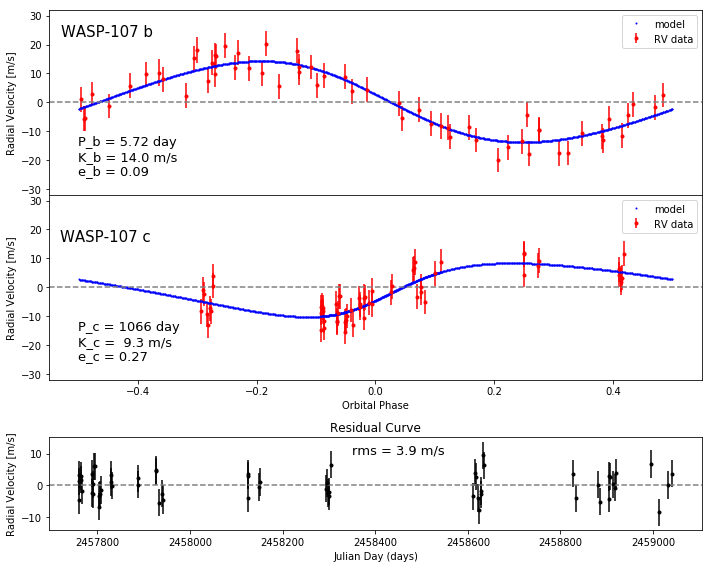

0.17335563511200203 0.12755911087531097
3.931304047164976 m/s
residual RVs =  [-4.64721127  1.25539484  3.28600931  2.90609708  1.7090504  -1.64355007
  3.69861605 -2.37295486 -2.87267546  0.28834854  6.04573001  5.96844522
 -6.7394777  -3.30055896 -2.88942064 -1.48924009  3.30302889  1.01489217
 -0.06917543  0.19953262  2.21497551  4.37969013  4.80379854 -5.47932165
 -2.58864981 -4.52485143  3.0559306  -4.03817471  3.56866665 -0.65041421
  1.12383606 -1.08401177  0.817319   -2.4700739  -3.47361648 -2.01689046
  6.44202544 -3.52993048  4.01662477  2.76508768 -4.06952434 -7.89103982
 -1.82791893 -2.79593093  9.48413714  6.26091316  3.69062457 -4.05542413
  0.1379688  -5.1255396   2.84080233 -4.23388672  2.66760491  0.25018296
 -0.70884631  3.91343474  6.78360616 -8.45204719  0.14717865  3.65435105]
RV length =  (60,)
(900000, 18)
rv error =  [4.35264473 4.295581   4.28831157 4.28831157 4.27049366 4.27401639
 4.35264473 4.34870281 4.295581   4.31036148 4.26350983 4.34087734
 4.25660852 4

In [58]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(10, 8))
outer_gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
inner_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[0], height_ratios=[1, 1], hspace=0)

ax1 = plt.subplot(inner_gs[0])
ax1.errorbar(phase, rv_folded_b2, yerr=rv_err_folded, 
             fmt='o', color='r', label="RV data", markersize=3)
ax1.plot(phase_model_bs, rv_folded_b3, 'bo', label="model", ms=1)
ax1.axhline(0, color='gray', ls='--')
ax1.set_ylabel("Radial Velocity [m/s]")
ax1.text(-0.53, 23, "WASP-107 b", fontsize=15, color='black', ha='left')
ax1.text(-0.5, -15, "P_b = 5.72 day ", fontsize=13, color='black', ha='left')
ax1.text(-0.5, -20, "K_b = 14.0 m/s ", fontsize=13, color='black', ha='left')
ax1.text(-0.5, -25, "e_b = 0.09", fontsize=13, color='black', ha='left')
ax1.legend()
ax1.set_ylim(-32, 32)
ax1.tick_params(labelbottom=False)  # 隐藏子图1的x轴标签，避免与子图2重叠

# 子图2（内层第二行）
ax2 = plt.subplot(inner_gs[1])
ax2.errorbar(phase2, rv_folded_c2, yerr=rv_err_folded, 
             fmt='o', color='r', label="RV data", markersize=3)
ax2.plot(phase_model_cs, rv_folded_c3, 'bo', label="model", ms=1)
ax2.axhline(0, color='gray', ls='--')
ax2.set_xlabel("Orbital Phase")
ax2.set_ylabel("Radial Velocity [m/s]")
#ax2.set_title("Phase-folded RV curve of WASP-107 c")
ax2.text(-0.53, 16, "WASP-107 c", fontsize=15, color='black', ha='left')
ax2.text(-0.5, -15, "P_c = 1066 day ", fontsize=13, color='black', ha='left')
ax2.text(-0.5, -20, "K_c =  9.3 m/s ", fontsize=13, color='black', ha='left')
ax2.text(-0.5, -25, "e_c = 0.27", fontsize=13, color='black', ha='left')
ax2.legend()
ax2.set_ylim(-32, 32)

# 子图3（外层第二行，与上部分保留间隙）
ax3 = plt.subplot(outer_gs[1])
ax3.errorbar(t, rv-(model_rv_b+gamma_mcmc+model_rv_c), yerr=rv_err_folded, 
             fmt='o', color='k', markersize=3)
ax3.axhline(0, color='gray', ls='--')
ax3.set_xlabel("Julian Day (days)")
ax3.set_ylabel("Radial Velocity [m/s]")
ax3.set_title("Residual Curve")
ax3.text(2458350, 10, "rms = 3.9 m/s", fontsize=13, color='black', ha='left')

#ax3.legend()

plt.tight_layout()
#plt.savefig("WASP-107_RV_Fitting_HIRES_prior_1207_jitter-detrend.pdf")
plt.show()

residuals = rv-(model_rv_b+gamma_mcmc+model_rv_c)
print(np.median(residuals), np.mean(residuals))
print(np.std(residuals), 'm/s')  
print('residual RVs = ', residuals[0:])
print('RV length = ',np.shape(residuals))
print(samples.shape)
print('rv error = ', rv_err_folded)

In [223]:
import corner
# this is slow
fig = corner.corner(samples[ :, :], labels = ["Kb", "eb", "wb", "t0c", "Pc", "Kc", "ec", "wc", "gamma", 
              "rp","u1","u2", "fp", "inc", "a", 'jitter', 'c0', 'c1'], 
                   truths = trans_medians)
#fig.savefig("corner_wasp_107_HIRES.pdf")

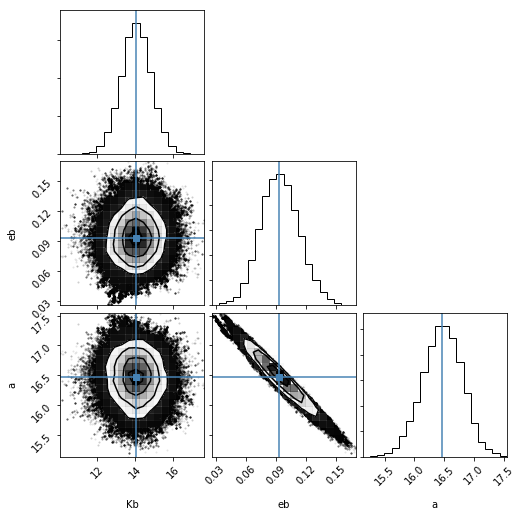

In [59]:
import corner

fig = corner.corner(samples[ : , [0,1,14] ], labels = ["Kb", "eb", "a"], 
                   truths = trans_medians[[0,1,14]])
#fig.savefig("corner_wasp_107_HIRES_prior_jitter1207-detrend.pdf")